# **Autoencoders in Computer Vision - Jupyter Notebook Tutorial**

# Section 1: Introduction to Autoencoders


NOTES:
Autoencoders are neural networks designed to learn compressed representations of data.
They work by encoding the input into a latent space and then decoding it back to reconstruct the input.

This is useful in scenarios where labeled data is scarce but we still want to learn meaningful features.
The learned features (latent vectors) are useful for:
- Image compression
- Noise reduction (denoising autoencoders)
- Anomaly detection (reconstruction error)
- Pretraining for classification or generative models
- Transfer learning


# Section 2: Setup and Imports

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Section 3: Load Dataset (FMNIST)

In [23]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])


# batch_size
batch_size = 512

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True,pin_memory=True, num_workers=4)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False,pin_memory=True, num_workers=4)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [24]:
train_data_size = len(trainloader.dataset) # type: ignore
test_data_size = len(testloader.dataset) # type: ignore

print(train_data_size)
print(test_data_size)

60000
10000


# Section 4: Define Basic Autoencoder

In [25]:
class CNN_Autoencoder(nn.Module):
    def __init__(self, encoded_space_dim=64, num_classes=10):
        super(CNN_Autoencoder, self).__init__()
        
        # ===== ENCODER =====
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Flatten(),  
            nn.Linear(32 * 7 * 7, encoded_space_dim) 
        )
        
        # ===== DECODER =====
        self.decoder = nn.Sequential(
            nn.Linear(encoded_space_dim, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  
            nn.Sigmoid()  
        )
        
        # ===== CLASSIFIER =====
        self.classifier = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        class_logits = self.classifier(encoded)
        return decoded, class_logits

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Autoencoder().to(device)

# optimizer and loss
criterion_recon = nn.MSELoss()
criterion_class = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Section 5: Training Autoencoder

In [27]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, class_logits = model(images)

        loss_recon = criterion_recon(outputs, images)
        loss_class = criterion_class(class_logits, labels)
        loss = loss_recon + loss_class  # Combo loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"[{epoch+1}/{num_epochs}] 🔥 Loss: {running_loss/len(trainloader):.4f}")

[1/10] 🔥 Loss: 1.5516
[2/10] 🔥 Loss: 1.1057
[3/10] 🔥 Loss: 1.0174
[4/10] 🔥 Loss: 0.9725
[5/10] 🔥 Loss: 0.9417
[6/10] 🔥 Loss: 0.9200
[7/10] 🔥 Loss: 0.9041
[8/10] 🔥 Loss: 0.8917
[9/10] 🔥 Loss: 0.8782
[10/10] 🔥 Loss: 0.8588


# Section 6: Visualize Reconstruction

In [ ]:
def show_reconstructions(n=10):
    model.eval()
    with torch.no_grad():
        for images, _ in trainloader:
            images = images.to(device)
            reconstructed, _ = model(images)
            break  # only one batch needed
    
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        # Original images on the first row
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title(f"Orig {i}")
        axes[0, i].axis('off')
        
        # Reconstructed images on the second row
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].set_title(f"Recon {i}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

 After visualizing the reconstructed images, the goal is to evaluate how well the model learned the compressed representation.
    If the reconstruction is good, it means the encoder has captured the essential information.

    These latent features can now be reused:
    - For clustering similar images
    - As inputs to a classifier
    - As building blocks for generative models like Variational Autoencoders or GANs

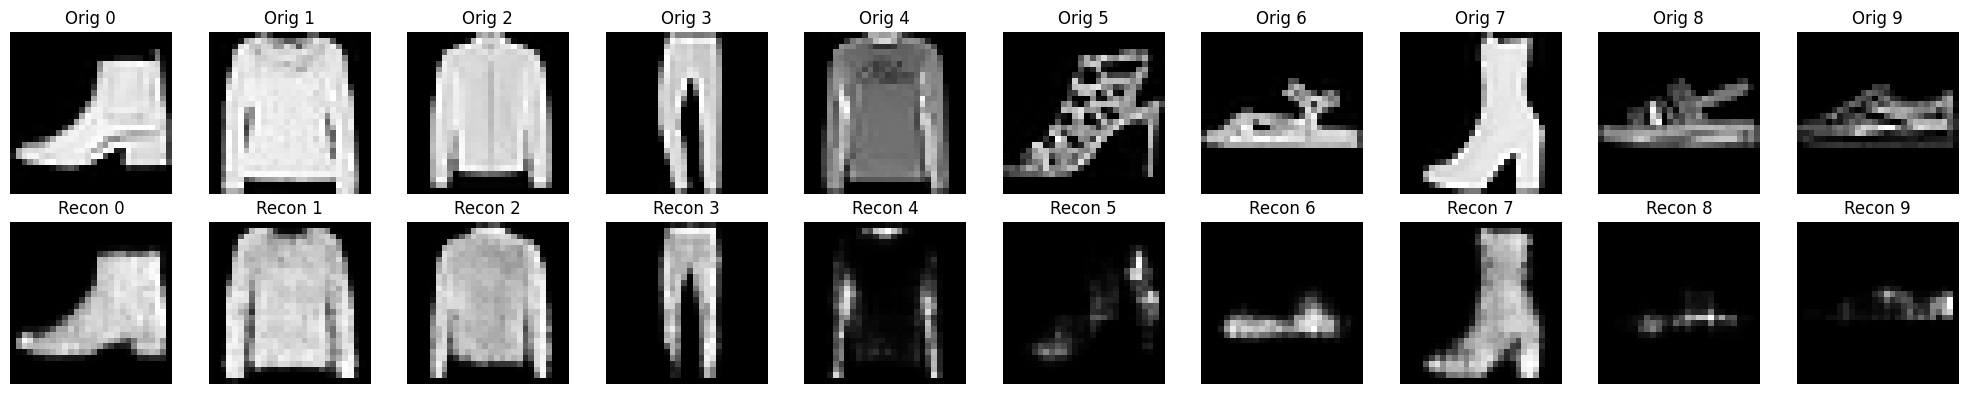

In [29]:
show_reconstructions()

# Section 7: Classification Using Latent Features

We now use the encoder's output (latent vector) to train a simple classifier.
This demonstrates the power of unsupervised representation learning.

In [30]:
num_samples = 10
latent_dim = 64  # This matches the encoded_space_dim from CNN_Autoencoder

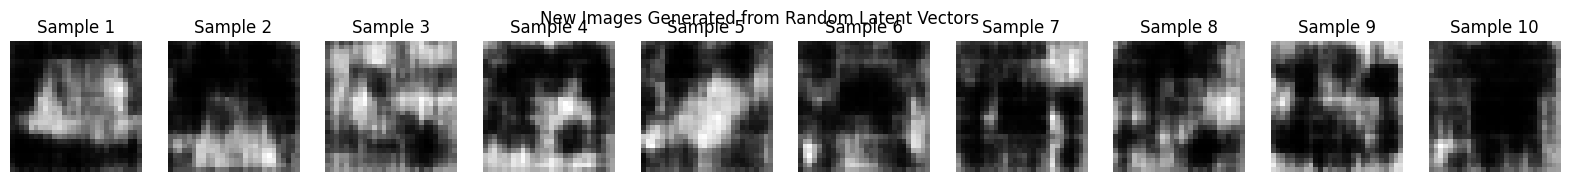

In [33]:
random_latents = torch.randn(num_samples, latent_dim).to(device)

# Decode to generate new images
model.eval()
with torch.no_grad():
    generated_images = model.decoder(random_latents)  # shape: [num_samples, 1, 28, 28]

# Visualize generated images
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
for i in range(num_samples):
    # generated_images[i] shape: [1, 28, 28], squeeze channel dim for imshow
    axes[i].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Sample {i+1}')

plt.suptitle("New Images Generated from Random Latent Vectors\n")
plt.show()